In [1]:
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import multivariate_normal

Make fake data:

In [2]:
# np.random.seed(123)
np.random.seed(456)

N = 5  # number of data points
t = np.sort(np.random.uniform(0, 1, size=N))
sig_y = np.random.uniform(0.1, 0.5, size=N)  # noise! MAGIC NUMBER
C = np.diag(sig_y**2)
# y = 10 + np.random.normal(0., sig_y, size=N)
y = 10 + np.zeros(N)

nsamples = 16384  # number of samples of the nonlinear parameter
P_lim = [1e0, 1e5]
P_samples = np.exp(np.random.uniform(np.log(P_lim[0]), 
                                     np.log(P_lim[1]),
                                     size=nsamples))

# hyperprior on linear parameters:
mu_th = np.array([0., 0, 0])
V = np.diag([1e2, 1e2, 1e2]) ** 2
# mu_th = np.array([0., 0])
# V = np.diag([1e3, 1e3]) ** 2

In [3]:
M = np.stack((np.ones((N, nsamples)),
              np.cos(2*np.pi*t[:, None] / P_samples[None]),
              np.sin(2*np.pi*t[:, None] / P_samples[None]))).T
# M = np.stack((np.ones((N, nsamples)),
#               np.cos(2*np.pi*t[:, None] / P_samples[None]))).T

In [4]:
def get_aA_bB(M, y, C, mu, V):
    Cinv = np.linalg.inv(C)
    Vinv = np.linalg.inv(V)
    
    A = C + M.dot(V).dot(M.T)
    Ainv = np.linalg.inv(A)
    Binv = Vinv + M.T.dot(Cinv).dot(M)
    B = np.linalg.inv(Binv)

    a = M.dot(mu)
    b = B.dot(M.T.dot(Cinv).dot(y) + Vinv.dot(mu))

    return a, A, b, B

In [5]:
lls = np.zeros(nsamples)
samples = np.zeros((nsamples, M.shape[-1]))
for i in range(nsamples):
    varK = (P_samples[i] / 1.)**(-2/3) * 45**2
#     V = np.diag([1e2**2, varK, varK])
    Vdiag = np.array([1e3, 1e3, 1e3]) ** 2
    V = np.diag(Vdiag)
    a, A, b, B = get_aA_bB(M[i], y, C, mu_th, V)
    lls[i] = multivariate_normal.logpdf(y, mean=a, cov=A)
    samples[i] = np.random.multivariate_normal(b, B)

/Users/apricewhelan/anaconda/envs/hq/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  if __name__ == '__main__':


In [6]:
uu = np.random.uniform(size=nsamples)
good_samples_mask = uu < np.exp(lls - lls.max())

In [7]:
good_samples_mask.sum()

3954

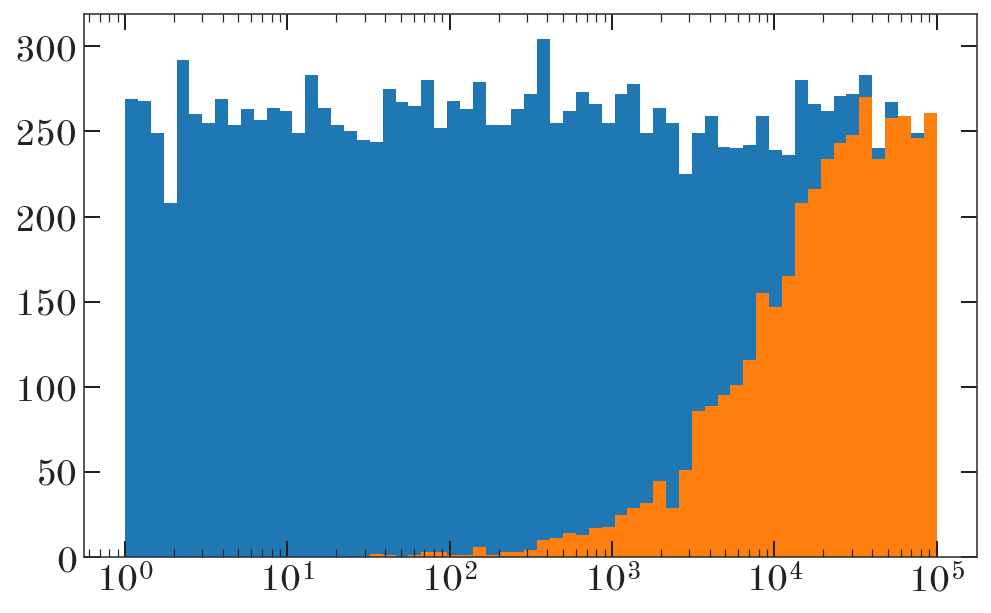

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
_, bins, *_ = ax.hist(P_samples, bins=np.geomspace(P_lim[0], P_lim[1], 64))
ax.hist(P_samples[good_samples_mask], bins=bins)
ax.set_xscale('log')

In [30]:
from thejoker import JokerParams, TheJoker, RVData
from thejoker.sampler.io import save_prior_samples
from astropy.time import Time
import h5py

In [20]:
pars = JokerParams(P_min=P_lim[0]*u.day, P_max=P_lim[1]*u.day, 
                   linear_par_Vinv=np.diag(1/Vdiag[:-1]))
joker = TheJoker(pars)
data = RVData(t=t, rv=y*u.km/u.s, stddev=sig_y*u.km/u.s, t0=Time(0., format='mjd'))

In [33]:
prior_samples = joker.sample_prior(size=100000)
prior_samples['e'] = np.zeros(len(prior_samples))
with h5py.File('/Users/apricewhelan/Downloads/test_joker.hdf5', 'w') as f:
    save_prior_samples(f, prior_samples, u.km/u.s)

In [34]:
joker_samples = joker.rejection_sample(data,
                                       prior_cache_file='/Users/apricewhelan/Downloads/test_joker.hdf5')

INFO: 9013 good samples after rejection sampling [thejoker.sampler.sampler]


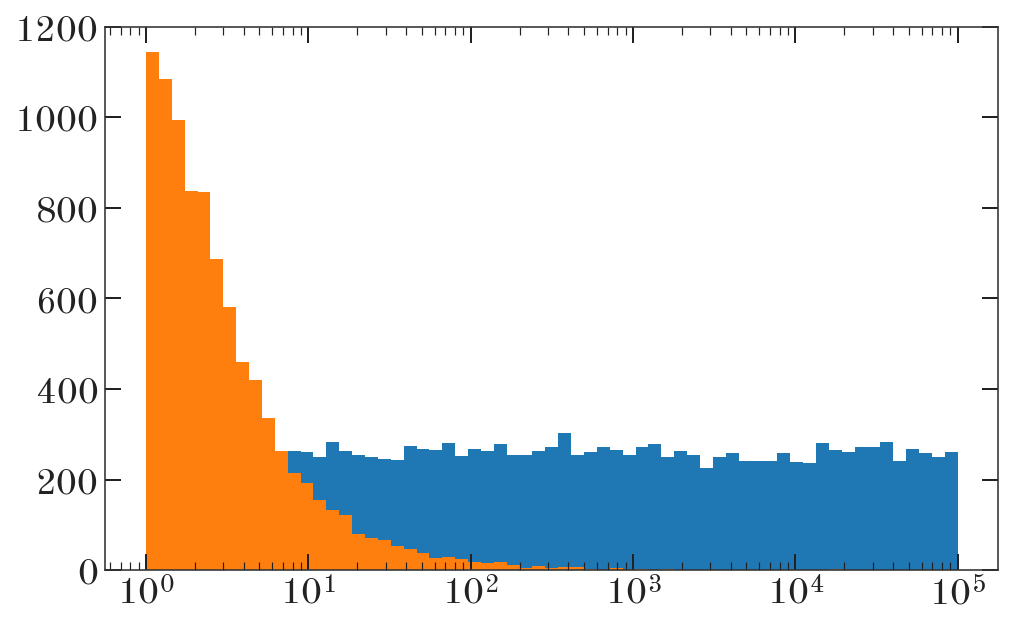

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
_, bins, *_ = ax.hist(P_samples, bins=np.geomspace(P_lim[0], P_lim[1], 64))
ax.hist(joker_samples['P'].value, bins=bins)
ax.set_xscale('log')

---

In [64]:
phase_samples = np.arctan2(samples[:, 2], samples[:, 1])
amp_samples = np.sqrt(samples[:, 1]**2 + samples[:, 2]**2)

In [65]:
from corner import corner

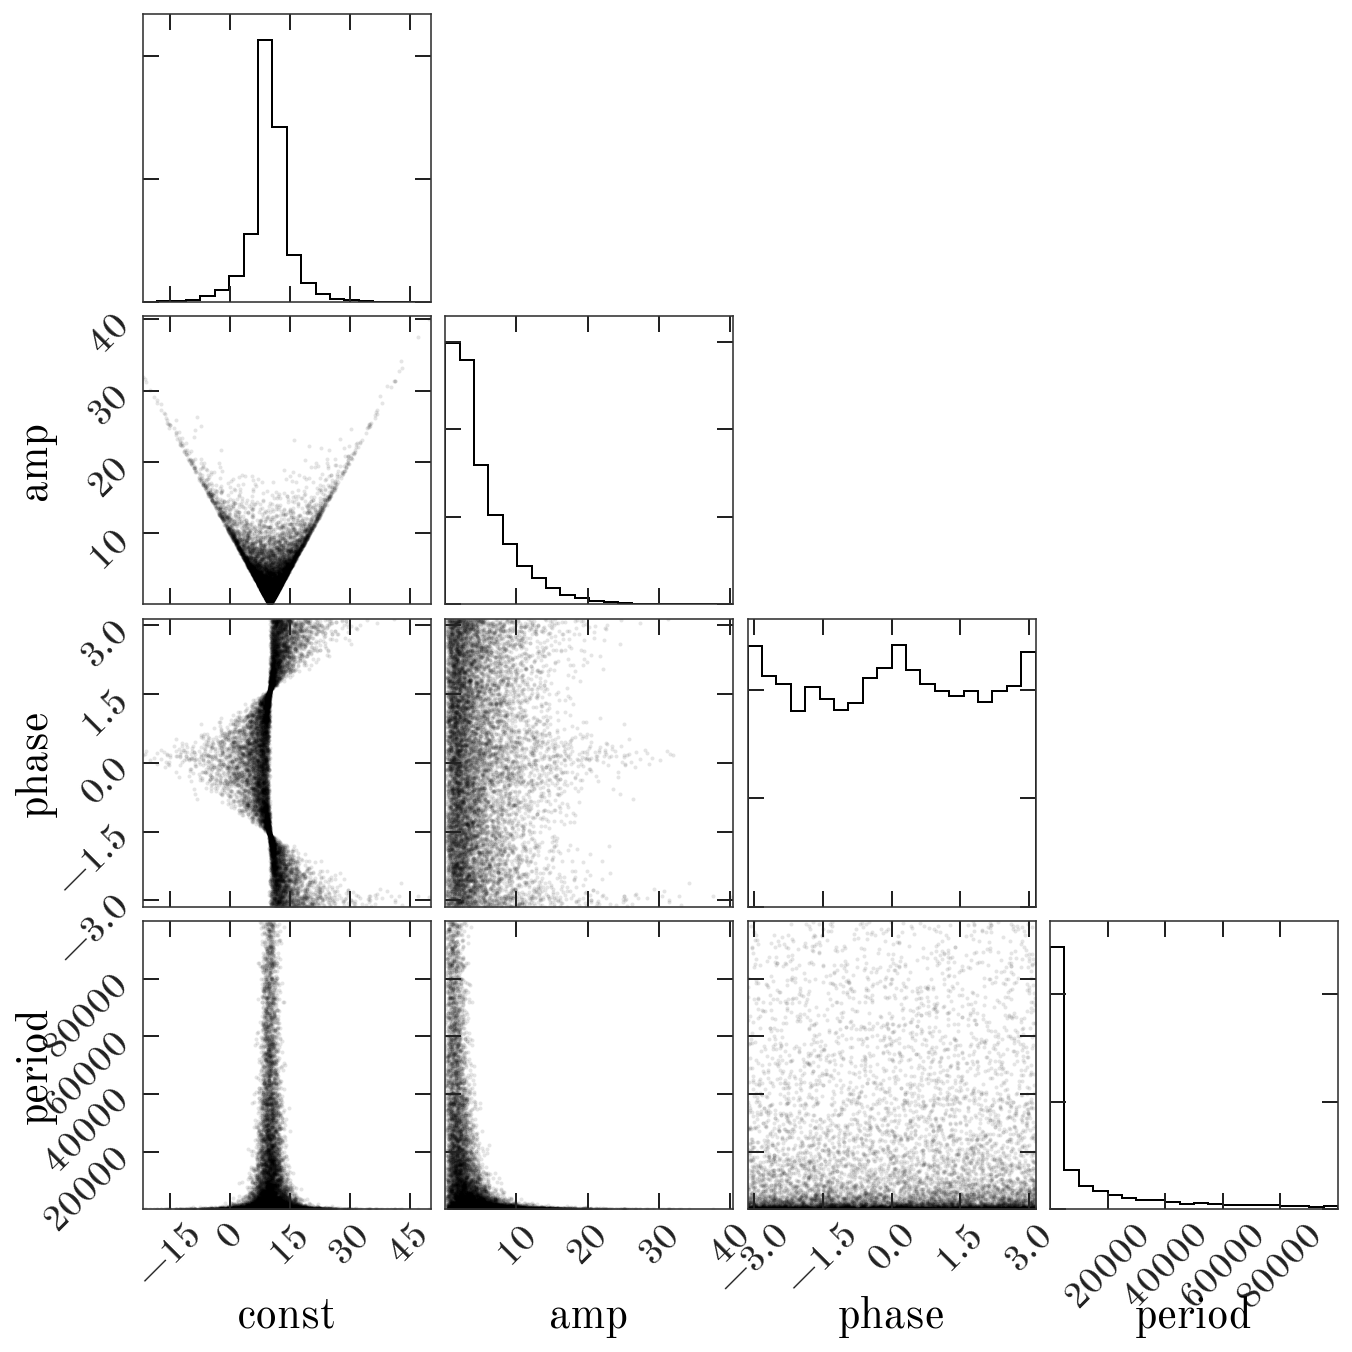

In [66]:
flat = np.stack((samples[:, 0], amp_samples, phase_samples, P_samples)).T[good_samples_mask]
_ = corner(flat, plot_contours=False, plot_density=False, labels=['const', 'amp', 'phase', 'period'])

(8.0, 12.0)

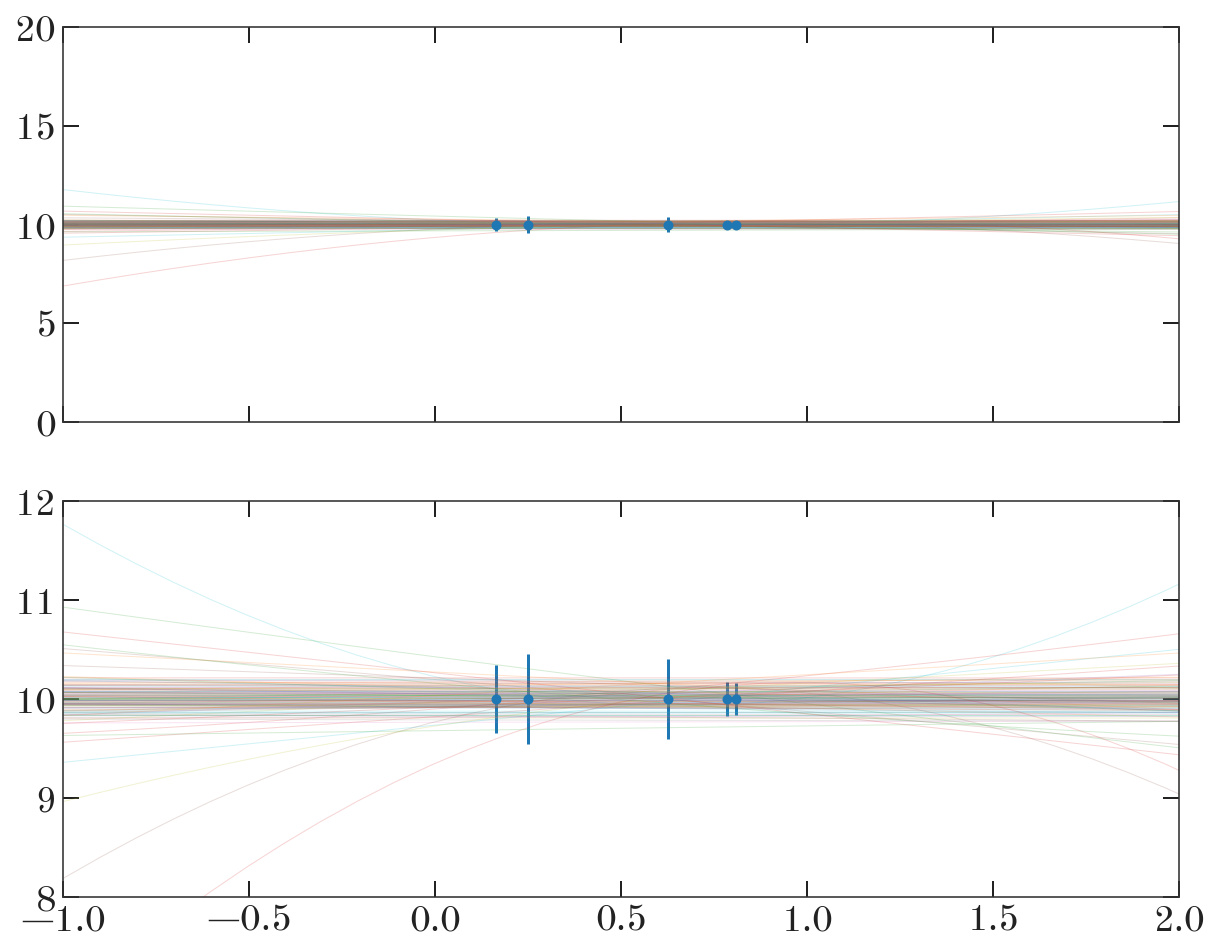

In [67]:
model_t = np.linspace(-1, 100., 1024)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

for ax in axes:
    ax.errorbar(t, y, sig_y, marker='o', ls='none')

    for j in np.where(good_samples_mask)[0][:128]:
        ax.plot(model_t, 
                (samples[j][0] + samples[j][1] * np.cos(2*np.pi*model_t / P_samples[j]) + 
                 samples[j][2] * np.sin(2*np.pi*model_t / P_samples[j])),
                marker='', lw=0.5, alpha=0.2)

axes[0].set_ylim(0, 20)
axes[1].set_xlim(-1, 2)
axes[1].set_ylim(np.mean(y) - 2, np.mean(y) + 2)